# Image Classification: Mask OR No Mask?

In this notebook, I will try to write an image classifier that can detect if the person in the image is wearing a mask or not. The data for this project was collected by scraping Google images using a browser extension.

The notebook will have the following sections:

* Image Preprocessing
* Build the model
* Training
* Model Evaluation
* Model Inference
* Future Improvements

We will begin by loading the dependencies first:

In [31]:
import tensorflow as tf
#from tensorflow import keras
import os
print(tf.__version__)

import numpy as np
import cv2
import imghdr
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,BatchNormalization

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.models import load_model

2.10.0


## Image Preprocessing

We will be first load our dataset and create a dataset object that yields batches of images from the subdirectories `with_mask` and `without_mask` with labels 0 and 1 corresponding to the two classes.

In [2]:
data = tf.keras.utils.image_dataset_from_directory('../data', batch_size = 8, image_size=(256,256))

Found 1171 files belonging to 2 classes.


Since we get a Batch dataset object, we cannot simply check the data but instead need to parse through them one by one

In [3]:
def go_next(data_object):
    data_iterator = data_object.as_numpy_iterator()
    return data_iterator.next()

In [4]:
def check_batch_img(batch):
    fig, ax = plt.subplots(ncols=4, figsize=(10,10))
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(batch[1][idx])

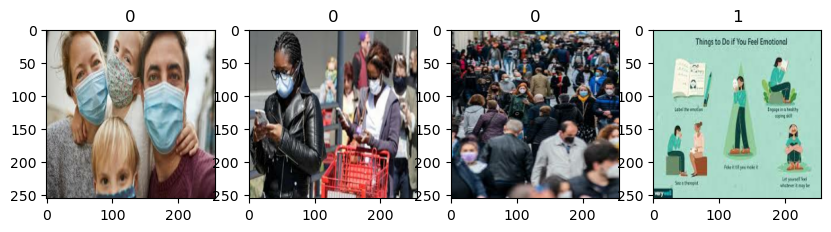

In [5]:
batch = go_next(data)

check_batch_img(batch)

Here we can see that 0 is for images with mask and 1 is the class_label for images without mask.

Now that we have scale our images:

In [6]:
# Checking 1 batch
batch[0].shape

(8, 256, 256, 3)

In [7]:
batch[0].max(), batch[0].min()

(255.0, 0.0)

The max value for an image is 255 and minimum is 0. In order to scale each image, we would need to divide the images by the max value

In [8]:
data = data.map(lambda x,y: (x/255, y))

In [9]:
# Checking the data now
batch = go_next(data)
batch[0].max(), batch[0].min()

(1.0, 0.0)

Now that we have scaled our images, we need to split our data into train-test-validation set

In [10]:
# Determining the size: train should be 70%, val should be 20% and test should be 10%
train_size, val_size, test_size = (int(len(data)*0.7), (int(len(data)*.2)+1), (int(len(data)*.1)+1))

# train takes the first 70% data
train = data.take(train_size)
# val skips the data already in train and then takes 20% from the remaining
val = data.skip(train_size).take(val_size)
# test skips the data already in train and validation set and then takes whats left
test = data.skip(train_size+val_size).take(test_size)

Now we will build our image classifier model!

## Building the Model

We will build a sequential model which will consist of a stack of layers connected sequenctially.

In [11]:
model = Sequential()

# Convolutional layer
model.add(Conv2D(filters = 64,kernel_size = 7, activation = 'relu', input_shape = (256,256,3)))
# to reduce chance of vanishing/exploding gradient
model.add(BatchNormalization())
# MaxPool2D uses a 2x2 kernel to subsample the input and limit risk of overfitting
model.add(MaxPool2D(pool_size = 2))

# Convolutional layer
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.2))
# Convolutional layer
model.add(BatchNormalization())
# Convolutional layer
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# MaxPool2D uses a 2x2 kernel to subsample the input and limit risk of overfitting
model.add(MaxPool2D(pool_size = 2))
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.2))

model.add(BatchNormalization())
# Convolutional layer
model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.2))

model.add(BatchNormalization())
# Convolutional layer
model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
# MaxPool2D uses a 2x2 kernel to subsample the input and limit risk of overfitting
model.add(MaxPool2D())
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.3))

# Flatten layer will convert its input into 1D array
model.add(Flatten())

model.add(BatchNormalization())
# Dense layer with 256 neurons with activation function "relu"
model.add(Dense(128, activation = 'relu'))
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.5))
# Dense layer with 128 neurons with activation function "relu"
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
# Dropout layer to try limit risk of overfitting
model.add(Dropout(rate = 0.3))

# Dense layer with 64 neurons with activation function "relu"
model.add(Dense(64, activation = 'relu'))

model.add(BatchNormalization())
# Final output will be between probability 0 and 1 
model.add(Dense(1, activation = 'sigmoid'))

Now we need to compile the model

In [12]:
model.compile("adam", loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

## Model training

In [14]:
# Callbacks
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='../logs')
checkpoint = tf.keras.callbacks.ModelCheckpoint("../best_model", save_best_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [15]:
#tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs = 50, validation_data = val, callbacks = [tensorboard, checkpoint, early_stopping])

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.5404

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 33s 166ms/step - loss: 0.8128 - accuracy: 0.5404 - val_loss: 0.7728 - val_accuracy: 0.4333
Epoch 2/50
102/102 [==============================] - 12s 112ms/step - loss: 0.7393 - accuracy: 0.5515 - val_loss: 1.0021 - val_accuracy: 0.4583
Epoch 3/50
102/102 [==============================] - 11s 112ms/step - loss: 0.6900 - accuracy: 0.5797 - val_loss: 0.7984 - val_accuracy: 0.4458
Epoch 4/50
102/102 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.5980

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 162ms/step - loss: 0.6830 - accuracy: 0.5980 - val_loss: 0.6579 - val_accuracy: 0.6208
Epoch 5/50
102/102 [==============================] - 12s 114ms/step - loss: 0.7084 - accuracy: 0.5944 - val_loss: 0.8505 - val_accuracy: 0.4958
Epoch 6/50
102/102 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.6189

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 16s 161ms/step - loss: 0.6789 - accuracy: 0.6189 - val_loss: 0.6332 - val_accuracy: 0.6667
Epoch 7/50
102/102 [==============================] - 12s 113ms/step - loss: 0.6045 - accuracy: 0.6716 - val_loss: 0.9372 - val_accuracy: 0.5333
Epoch 8/50
102/102 [==============================] - 12s 112ms/step - loss: 0.6839 - accuracy: 0.5870 - val_loss: 0.6924 - val_accuracy: 0.6792
Epoch 9/50
102/102 [==============================] - 12s 116ms/step - loss: 0.6360 - accuracy: 0.6471 - val_loss: 0.6342 - val_accuracy: 0.7042
Epoch 10/50
102/102 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6667

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 18s 172ms/step - loss: 0.6219 - accuracy: 0.6667 - val_loss: 0.5774 - val_accuracy: 0.7292
Epoch 11/50
102/102 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6703

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 165ms/step - loss: 0.6116 - accuracy: 0.6703 - val_loss: 0.5725 - val_accuracy: 0.7250
Epoch 12/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5991 - accuracy: 0.7059 - val_loss: 0.6772 - val_accuracy: 0.6292
Epoch 13/50
102/102 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.6765

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 168ms/step - loss: 0.6008 - accuracy: 0.6765 - val_loss: 0.5622 - val_accuracy: 0.7000
Epoch 14/50
102/102 [==============================] - 12s 115ms/step - loss: 0.6279 - accuracy: 0.6630 - val_loss: 1.4196 - val_accuracy: 0.4917
Epoch 15/50
102/102 [==============================] - 12s 114ms/step - loss: 0.6442 - accuracy: 0.6152 - val_loss: 0.8781 - val_accuracy: 0.6125
Epoch 16/50
102/102 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.6826

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 18s 172ms/step - loss: 0.6058 - accuracy: 0.6826 - val_loss: 0.5300 - val_accuracy: 0.7125
Epoch 17/50
102/102 [==============================] - 12s 115ms/step - loss: 0.6053 - accuracy: 0.6777 - val_loss: 0.7833 - val_accuracy: 0.5917
Epoch 18/50
102/102 [==============================] - 12s 117ms/step - loss: 0.5994 - accuracy: 0.6814 - val_loss: 0.6031 - val_accuracy: 0.7208
Epoch 19/50
102/102 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.6900

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 18s 171ms/step - loss: 0.5930 - accuracy: 0.6900 - val_loss: 0.5211 - val_accuracy: 0.7708
Epoch 20/50
102/102 [==============================] - 12s 116ms/step - loss: 0.5681 - accuracy: 0.7120 - val_loss: 0.5283 - val_accuracy: 0.7833
Epoch 21/50
102/102 [==============================] - 12s 114ms/step - loss: 0.5859 - accuracy: 0.6998 - val_loss: 0.5453 - val_accuracy: 0.7250
Epoch 22/50
102/102 [==============================] - 12s 117ms/step - loss: 0.5707 - accuracy: 0.7243 - val_loss: 0.5238 - val_accuracy: 0.7500
Epoch 23/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5753 - accuracy: 0.7071 - val_loss: 1.0652 - val_accuracy: 0.5875
Epoch 24/50
102/102 [==============================] - 12s 115ms/step - loss: 0.6141 - accuracy: 0.6728 - val_loss: 0.5591 - val_accuracy: 0.7417
Epoch 25/50
102/102 [==============================] - 12s 114ms/step - loss: 0.5767 - accuracy: 0.7169 - val_loss: 4.4379 - val_accurac

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 164ms/step - loss: 0.5792 - accuracy: 0.6961 - val_loss: 0.5148 - val_accuracy: 0.7417
Epoch 30/50
102/102 [==============================] - 12s 114ms/step - loss: 0.5991 - accuracy: 0.6973 - val_loss: 0.5483 - val_accuracy: 0.7375
Epoch 31/50
102/102 [==============================] - 12s 114ms/step - loss: 0.5955 - accuracy: 0.6838 - val_loss: 0.5458 - val_accuracy: 0.7417
Epoch 32/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5864 - accuracy: 0.6887 - val_loss: 0.5201 - val_accuracy: 0.7333
Epoch 33/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5598 - accuracy: 0.7218 - val_loss: 0.5411 - val_accuracy: 0.7250
Epoch 34/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5617 - accuracy: 0.7292 - val_loss: 0.5394 - val_accuracy: 0.7458
Epoch 35/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5679 - accuracy: 0.7059 - val_loss: 0.5961 - val_accurac

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 162ms/step - loss: 0.5400 - accuracy: 0.7353 - val_loss: 0.4869 - val_accuracy: 0.7750
Epoch 40/50
102/102 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.7525

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 164ms/step - loss: 0.5151 - accuracy: 0.7525 - val_loss: 0.4851 - val_accuracy: 0.7792
Epoch 41/50
102/102 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7353

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 163ms/step - loss: 0.5254 - accuracy: 0.7353 - val_loss: 0.4752 - val_accuracy: 0.7917
Epoch 42/50
102/102 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7549

INFO:tensorflow:Assets written to: ..\best_model\assets


INFO:tensorflow:Assets written to: ..\best_model\assets


102/102 [==============================] - 17s 159ms/step - loss: 0.5124 - accuracy: 0.7549 - val_loss: 0.4537 - val_accuracy: 0.7792
Epoch 43/50
102/102 [==============================] - 12s 113ms/step - loss: 0.5344 - accuracy: 0.7463 - val_loss: 0.5295 - val_accuracy: 0.7667
Epoch 44/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5147 - accuracy: 0.7512 - val_loss: 0.4541 - val_accuracy: 0.7958
Epoch 45/50
102/102 [==============================] - 12s 115ms/step - loss: 0.4718 - accuracy: 0.8015 - val_loss: 0.4655 - val_accuracy: 0.7667
Epoch 46/50
102/102 [==============================] - 12s 115ms/step - loss: 0.5147 - accuracy: 0.7488 - val_loss: 0.4603 - val_accuracy: 0.8083
Epoch 47/50
102/102 [==============================] - 12s 116ms/step - loss: 0.4921 - accuracy: 0.7794 - val_loss: 0.4880 - val_accuracy: 0.7667
Epoch 48/50
102/102 [==============================] - 12s 117ms/step - loss: 0.4778 - accuracy: 0.7721 - val_loss: 0.4607 - val_accurac

# Model Evaluation

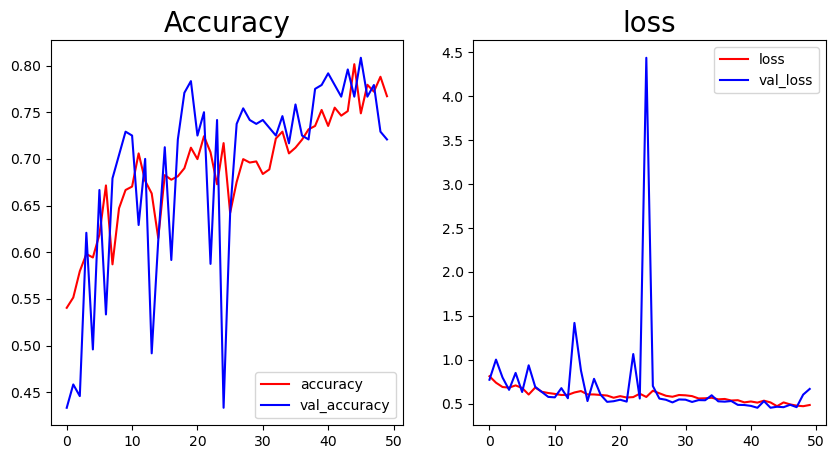

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


ax[0].plot(hist.history['accuracy'], color = 'red', label = 'accuracy')
ax[0].plot(hist.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
ax[0].set_title("Accuracy", fontsize = 20)
ax[0].legend(loc = "lower right")

ax[1].plot(hist.history['loss'], color = 'red', label = 'loss')
ax[1].plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
ax[1].set_title("loss", fontsize = 20)
ax[1].legend(loc = "upper right")


plt.show()


The validation loss seem to have a sharp spikes initially but then decreased gradually. The accuracy on the validation also had a sharp spike  but then seem to become a lot more stable. There seem to be some overfitting especially since the data set is pretty small. 

Our dataset was slightly imbalanced so next we will calculate the Precision, Recall and Accuracy to get the true performance of our model.

Precision will quantify how many correct predictions of "without mask" were made. It will be the ratio of correctly predicted "without mask" images divided by the sum of the total true positives and false positives.

Recall = True Positives/(True postives + False Negative)

In [17]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [18]:
def model_metric (batch_data):
    for test_batch in batch_data.as_numpy_iterator():
        x_test, y_test = test_batch
        yhat = model.predict(x_test)
        precision.update_state(y_test, yhat)
        recall.update_state(y_test, yhat)
        accuracy.update_state(y_test, yhat)
    print(f'Accuracy is {accuracy.result().numpy()*100}, Precision is {precision.result().numpy()*100} and Recall is {recall.result().numpy()*100}')

In [19]:
model_metric(test)

1/1 [==============================] - 0s 415ms/step
Accuracy is 73.9130437374115, Precision is 62.068963050842285 and Recall is 81.81818127632141


Hence, with precision 62.1% we can conclude that about 62% of the positive labels were actually correct and from recall of 81.7% we can conclude that around 81% of the actual postives were correctly identified which is quite good for our small dataset!

So the model is currently able to detect 62% of images without mask correctly out of all the images it thinks belong to the "without mask" class and 81% of the actual postives were correctly identified which is quite low! so we will need to modify the threshold value a bit.

Raising the threshold will reduces false positives and so it will raise precision but the number of false postives will increase so recall will decrease even further!

## Testing our Model

In [48]:
def predict_mask(image_name):
    image_path = os.path.join('../',image_name + '.jpeg')

    fig, ax = plt.subplots(ncols=1, figsize=(8,6))
    img = cv2.imread(image_path)
    
    # Scale
    resize = tf.image.resize(img, (256, 256))
    # Predict
    yhat = model.predict(np.expand_dims(resize/255, 0))
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if yhat > 0.55:
        ax.title.set_text('Image has no Mask')
    else:
        ax.title.set_text('image has a Mask!')
    print(yhat)
    plt.show()

#### Test 1

1/1 [==============================] - 0s 29ms/step
[[0.16135846]]


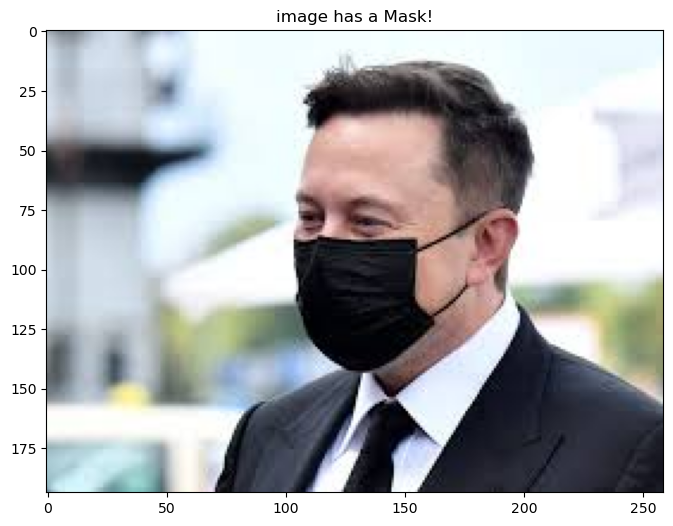

In [49]:
path_1 = 'mask_test'

predict_mask(path_1)

1/1 [==============================] - 0s 27ms/step
[[0.6807179]]


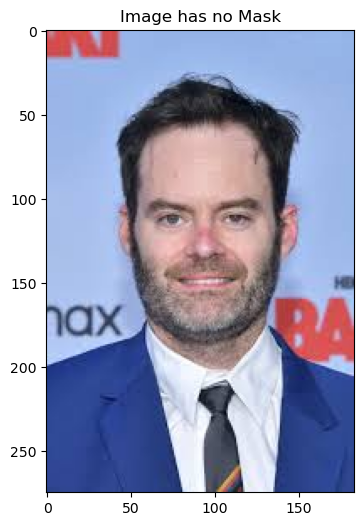

In [50]:
path_2 = 'no_mask_test'
predict_mask(path_2)

## Save Model

In [51]:
model.save(os.path.join('../model', 'mask_detection.h5'))

## Conclusion

This concludes the notebook. The model performed fairly well but it can be improved further by adding more data and choosing a more complex model architecture. The training set needs more variety. There was some overfitting but was reduced signigicantly by introducing Dropout layers and the vanishing/exploding gradient problem was addressed by adding BatchNormalization. We can perform image augmentation to increase our training set but I will not be doing so in this notebook. We can achieve better results with transfer learning as well but for that we would definitely need a larger training dataset.